In [1]:
from data import read_preprocessed_data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from inertia import calculate_inertias

color_pallete = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]

data_scaled = read_preprocessed_data()

c:\dadada4\Mad\customer-profile-analysis\data/marketing_campaign.csv


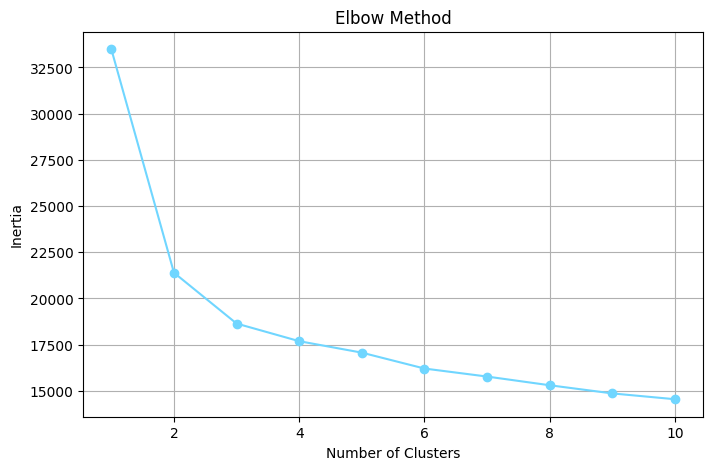

In [2]:
# Liczymy bezwładność klastrów (sumę kwadratów odległości od centroidów)
inertias = calculate_inertias(data_scaled)

# Szukamy "łokcia" na wykresie
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertias, marker="o", color=color_pallete[0])
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)

Text(0.5, 1.0, 'Metoda k-średnich z wizualizacją PCA')

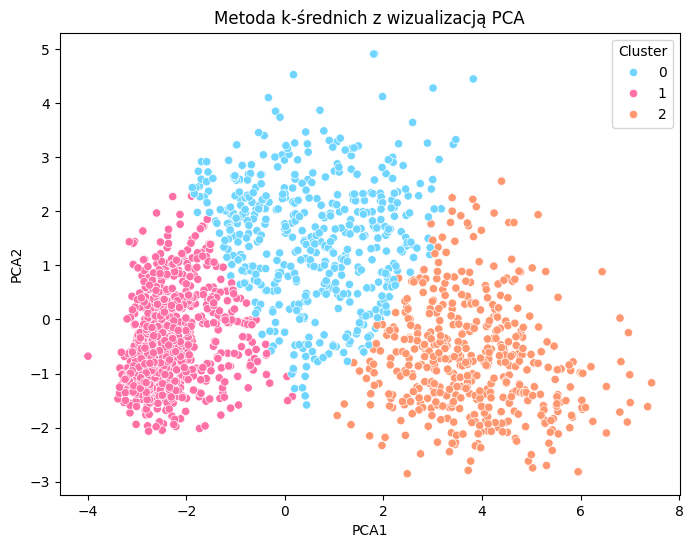

In [3]:
# Stosujemy metodę k-średnich dla wybranej liczby klastrów
optimal_k = 3

# Używamy random_state = 42, aby zapewnić, że klastry będą takie same z każdym uruchomieniem
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data_scaled["Cluster"] = kmeans.fit_predict(data_scaled)

# Dwuwymiarowa wizualizacja danych za pomocą analizy głównych składowych (PCA)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_scaled.drop("Cluster", axis=1))
data_scaled["PCA1"] = pca_components[:, 0]
data_scaled["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_scaled, x="PCA1", y="PCA2", hue="Cluster", palette=color_pallete[:3]
)
plt.title("Metoda k-średnich z wizualizacją PCA")

In [4]:
#wariancja wyjaśniona przez PCA1 oraz PCA2
print("PCA1: ", round(pca.explained_variance_ratio_[0], 2))
print("PCA2: ", round(pca.explained_variance_ratio_[1], 2))
#część całkowitej wariancji danych jaką udało się przedstawić na wykresie
print("Suma wyjaśnionej wariancji: ", round(pca.explained_variance_ratio_.sum(), 2))

PCA1:  0.45
PCA2:  0.1
Suma wyjaśnionej wariancji:  0.55


In [5]:
# Wczytujemy nieustandaryzowane dane
original_data = read_preprocessed_data(std=False, le=False)

# Kopiujemy kolumnę "Cluster"
original_data["Cluster"] = data_scaled["Cluster"]

# Obliczamy średnie dla danych numerycznych i grupujemy dane według klastrów
cluster_summary = original_data.groupby("Cluster").mean(numeric_only=True)

# Obliczamy mediany dla danych kategorycznych
object_cols = original_data.select_dtypes(include="object").columns
for col in object_cols:
    mode_per_cluster = original_data.groupby("Cluster")[col].agg(lambda x: x.mode()[0])
    cluster_summary[col + "_mode"] = mode_per_cluster

# Zliczamy ilość danych w klastrze
cluster_summary["Count"] = original_data["Cluster"].value_counts().sort_index()

# Podsumowanie klastrów
cluster_summary.transpose()

c:\dadada4\Mad\customer-profile-analysis\data/marketing_campaign.csv


Cluster,0,1,2
Income,57138.590226,34360.28777,75526.617021
Kidhome,0.206767,0.775951,0.038685
Teenhome,0.855263,0.448099,0.210832
Recency,47.528195,49.355601,49.694391
MntWines,423.328947,38.903392,583.500967
MntFruits,22.233083,4.781089,68.497204
MntMeatProducts,129.990602,21.470709,441.246071
MntFishProducts,30.174613,6.695786,101.934963
MntSweetProducts,21.927152,4.910586,70.856327
MntGoldProds,55.636661,14.624872,78.055168


c:\dadada4\Mad\customer-profile-analysis\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


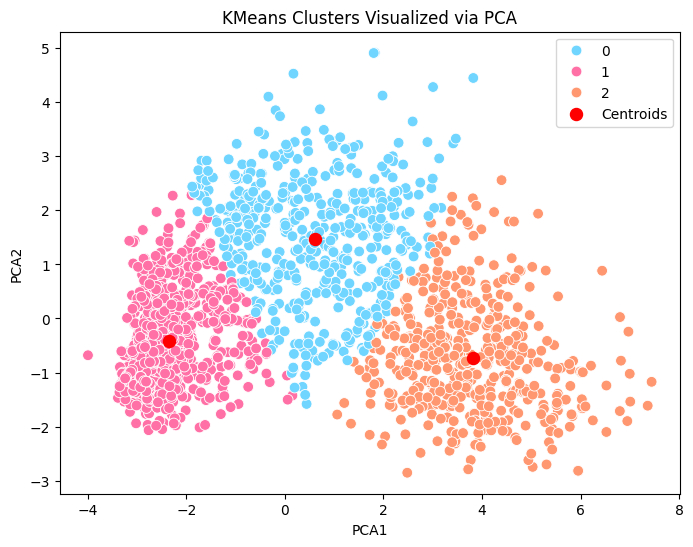

In [6]:
# Dodajemy centroidy do wykresu
centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_scaled, x="PCA1", y="PCA2", hue="Cluster", palette=color_pallete[:3], s=60
)
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    marker="o",
    s=75,
    color="red",
    label="Centroids",
)
plt.title("KMeans Clusters Visualized via PCA")
plt.legend()